# Inference

Test the trained and saved on model on resized crops of Eilat images.

## Imports

In [1]:
# load custom scripts
from utils import *
import config 

# import the necessary packages
from imutils import paths
from skimage import io
from torchmetrics import ConfusionMatrix
from torchvision import transforms
import albumentations as A
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import torch
import torchmetrics

## Controlling sources of randomness

In [2]:
# Set seed
SEED = 42
seed_all(SEED)

## Plot function

In [3]:
classes = {0: 'no label',
           1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: '(macro) algae',
           8: 'seagrass',
           9: 'unknown'
          }

In [4]:
cmap = mpl.colors.ListedColormap(['1',
                                  (0.3215686274509804, 0.32941176470588235, 0.6392156862745098),
                                  (0.611764705882353, 0.6196078431372549, 0.8705882352941177),
                                  (0.8392156862745098, 0.3803921568627451, 0.4196078431372549),
                                  (0.5490196078431373, 0.42745098039215684, 0.19215686274509805),
                                  (0.9058823529411765, 0.796078431372549, 0.5803921568627451),
                                  (0.8705882352941177, 0.6196078431372549, 0.8392156862745098),
                                  (0.38823529411764707, 0.4745098039215686, 0.2235294117647059),
                                  (0.7098039215686275, 0.8117647058823529, 0.4196078431372549),
                                  (0.6470588235294118, 0.3176470588235294, 0.5803921568627451)
                                 ])


In [5]:
def prepare_plot(image, gtLabel, predLabel):

    # plot the original image, its mask, and the predicted mask
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    im1 = ax[0].imshow(unnormalize(image[0]).cpu().detach().permute(1, 2, 0))
    im2 = ax[1].imshow(gtLabel.numpy(),
                       cmap = cmap,
                       vmin=0, vmax=9)
    im3 = ax[2].imshow(predLabel.numpy(),
                       cmap = cmap,
                       vmin=0, vmax=9)

    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Labels")
    ax[2].set_title("Predicted Labels")

    # add colour bar
    cbar = fig.colorbar(im3, ticks=list(classes.keys()), fraction=0.045)
    cbar.ax.set_yticklabels(list(classes.values()))

    # set the layout of the figure and display it
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    plt.show()
        
    print("[INFO] Accuracy ", accuracyAGT(predLabel, gtLabel))
    print("[INFO] Accuracy ", acc(predLabel, gtLabel))

    '''
    cf_matrix = np.array(confmat(predLabel, gtLabel))

    # confusion matrix
    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                     fmt='.2%', cmap='Blues', linewidths=.5, ax=ax)

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(list(classes.values()),rotation = 30)
    ax.yaxis.set_ticklabels(list(classes.values()),rotation = 30)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    '''

## Testing loop

In [6]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk
        image = io.imread(imagePath)
        
        # load the labels from disk
        groundTruthPath = '/data/jantina/data/CoralNet/inference/labels/'+scene+ imagePath.split(os.path.sep)[-1]+'.tif'
        gtLabel = io.imread(groundTruthPath)
    
        # apply transformation
        transformed = test_transform(image=image, mask=gtLabel)
        image = transformed["image"]
        gtLabel = transformed["mask"]
        
        # create image tensor
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image)
        image = image.to("cuda")
        
        # create mask tensor
        asarray = lambda x: torch.tensor(np.array(x), dtype=torch.long)
        gtLabel = asarray(np.expand_dims(gtLabel, 0))

        # prediction
        predLabel = model(image).squeeze()
        predLabel = torch.argmax(predLabel, dim=0)
        predLabel = predLabel.cpu()
        
        # prepare a plot for visualization
        prepare_plot(image, gtLabel.squeeze(), predLabel)
        
    return image, gtLabel.squeeze(), predLabel    

In [7]:
test_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), interpolation=cv2.INTER_NEAREST),
    #A.Resize(width=128, height=128, interpolation=cv2.INTER_NEAREST),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

## Make predictions

In [8]:
# initialize metrics
confmat = ConfusionMatrix(num_classes=10)
acc = torchmetrics.Accuracy(ignore_index=0)

In [9]:
scene = 'scene_3/'

In [ ]:
# load the image paths corresponding to the images
print("[INFO] loading up test image paths...")
directory = '/data/jantina/data/CoralNet/inference/images/'+scene

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
#unet = torch.load("/data/jantina/data/CoralNet/dataset/small/output/unet.pth").to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/medium/output/unet.pth").to(config.DEVICE)
#unet = torch.load(config.MODEL_PATH).to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/output_dense/unet.pth").to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/output/unet2.pth").to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/output/weighted.pth").to(config.DEVICE)
#unet = torch.load("/data/jantina/data/CoralNet/dataset/output/eilat.pth").to(config.DEVICE)


conf = np.zeros((10,10)) 
totalaccu = 0
countacc = 0

for path in os.listdir(directory):
    print(path)
    imagePath = os.path.join(directory, path)
    image, gtLabel, predLabel = make_predictions(unet, imagePath)
    
    conf += np.array(confmat(predLabel, gtLabel.squeeze()))
        
    if torch.sum(gtLabel)!=0:
        countacc += 1
        totalaccu += acc(predLabel, gtLabel)
        
    plt.imshow(unnormalize(image[0]).cpu().detach().permute(1, 2, 0))
    plt.axis('off')
    plt.show()
    
    plt.imshow(gtLabel.numpy(),
               cmap = cmap,
               vmin=0, vmax=9)
    plt.axis('off')
    plt.show()
    
    plt.imshow(predLabel.numpy(), 
               cmap = cmap,
               vmin=0, vmax=9)
    
    # add colour bar
    cbar = plt.colorbar(ticks=list(classes.keys()), fraction=0.045)
    cbar.ax.set_yticklabels(list(classes.values()))
    plt.axis('off')
    plt.show()

In [11]:
print("[INFO] The accuracy of the test set is: ", totalaccu/countacc)

[INFO] The accuracy of the test set is:  tensor(0.6205)


## Normalized Confusion Matrix

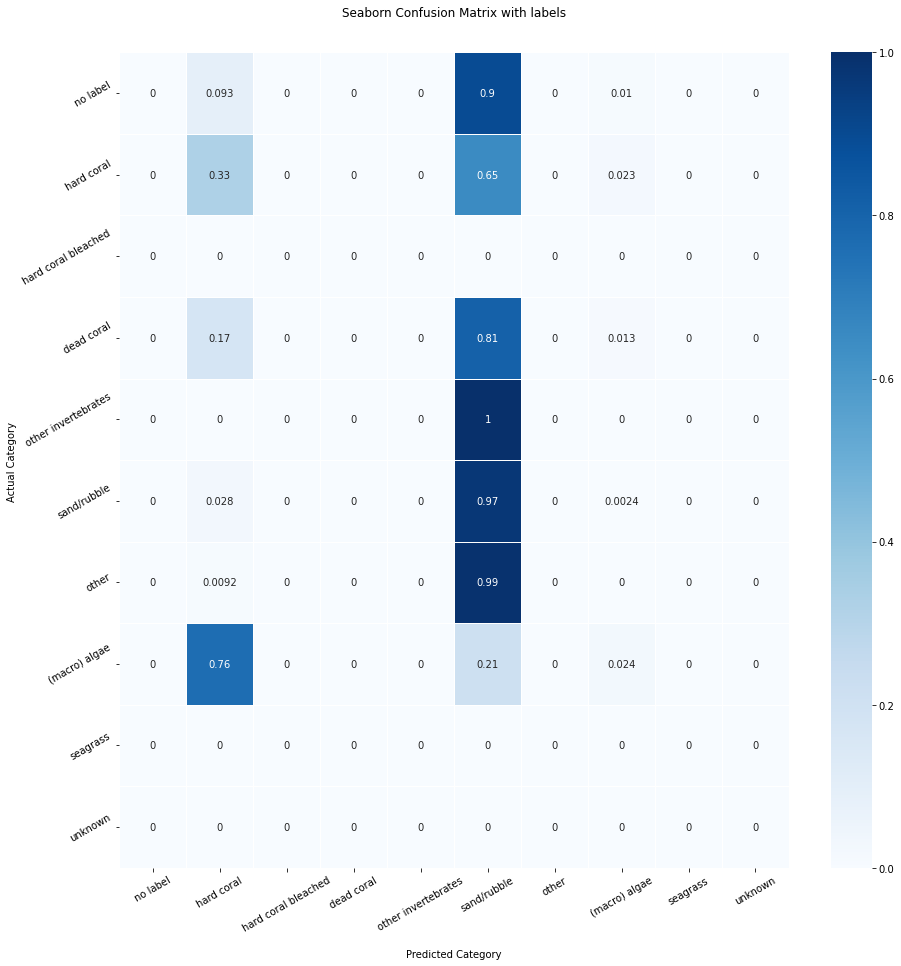

In [12]:
norm = np.copy(conf)

for i in range(len(conf)):
    if conf.sum(axis=1)[:, np.newaxis][i] != 0:
        norm[i,:] = conf[i,:] / conf.sum(axis=1)[:, np.newaxis][i]
        
# confusion matrix
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(norm, annot=True, cmap='Blues', linewidths=.5, ax=ax)

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(list(classes.values()),rotation = 30)
ax.yaxis.set_ticklabels(list(classes.values()),rotation = 30)

plt.show()